In [2]:
import h5py
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn import svm
from tqdm import tqdm
prefitfile = "Result MCFM Real Data/fitresult_prefit.hdf5"
# Set the colour palette to "bright"
sns.set_palette("bright")
# Create folders
folders = ["Result MCFM Real Data", "Figure MCFM Real Data"]
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [3]:
# General information
nproc = "31"
lhapdfs = ["NNPDF31", "MSHT20"] # NNPDF31 or MSHT20
ewcorr = "none"
pgoal = "0.01"

In [4]:
# Select the files to be compared
def sel_files(parts_cp):
    files_cp_pT = []
    files_cp_eta = []
    for part in parts_cp:
        for lhapdf in lhapdfs:
            files_cp_pT.append(f"Result MCFM Real Data/Z_data_{lhapdf}_31_" + part + "_none_0.001_pT.txt")
            files_cp_eta.append(f"Result MCFM Real Data/Z_data_{lhapdf}_31_" + part + "_none_0.001_eta.txt")
    return files_cp_pT, files_cp_eta
def check_pgoal(files):
    for i, file in enumerate(files):
        if not file.startswith("Result MCFM Real Data/"):
            file = "Result MCFM Real Data/" + file
        if os.path.exists(file):
            continue
        else:
            files[i] = file.replace("0.001", "0.01")
    return files
parts_cp = ["resNLOp", "resNNLO"]

In [5]:
# Description of part
part_dict = {"resNLOp": r"$\mathrm{N}^3$LL+NLO", "resNNLO": r"$\mathrm{N}^3$LL+NNLO"}

In [6]:
# Define the bins
bins_pT = np.array([0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 23, 27, 32, 40, 55, 100])
bins_eta = np.arange(0, 2.75, 0.25)
bin_widths_pT = np.diff(bins_pT).reshape((-1, 1))
bin_widths_eta = np.diff(bins_eta)
bin_widths = (bin_widths_eta * bin_widths_pT).flatten()

In [7]:
# Define the colours
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [8]:
# Extract data from text file
def extract(file):
    if not file.startswith(".sys."):
        if file.endswith(".hdf5"):
            file = h5py.File(file, "r")
            values, errors = zip(*file["data_ZptVGen_absYVGen"])
            values, errors = np.array(values), np.sqrt(np.array(errors))
            values_pT = np.cumsum(values.reshape(-1, 10), axis=1)[:, -1]/np.diff(bins_pT)
            values_eta = np.sum(values.reshape(20, 10), axis=0)/np.diff(bins_eta)
            errors_pT = np.cumsum(errors.reshape(-1, 10), axis=1)[:, -1]/np.diff(bins_pT)
            errors_eta = np.sum(errors.reshape(20, 10), axis=0)/np.diff(bins_eta)
            return values_pT, values_eta, errors_pT, errors_eta
        else:
            # Open the text file
            with open(file, "r") as f:
                if file.endswith("pT.txt") or any(file.endswith(f"pT_{i}.txt") for i in range(3, 12+1)) or file.endswith("eta.txt"):
                    # Skip the first 5 rows
                    for i in range(5):
                        f.readline()
                    # Extract the data
                    data = [line.split() for line in f.readlines()]
                    if file.endswith("pT.txt") or any(file.endswith(f"pT_{i}.txt") for i in range(3, 42+1)):
                        edges = np.append(np.array([float(row[0]) for row in data]), 100.0)
                    else:
                        edges = np.append(np.array([float(row[0]) for row in data]), 5.0)
                    values = np.array([float(row[2])/1000 for row in data])/np.diff(edges)
                    errors = np.array([float(row[3])/1000 for row in data])/np.diff(edges)
                    return edges, values, errors

In [9]:
# Add texts to the plot
def add_plot_text(ax):
    ax.text(1, 1.06, r"16.8 fb$^{-1}$ (13 TeV)", wrap=True, fontname="Arial", fontsize=16, transform=ax.transAxes, ha="right", va="top")
    ax.text(0, 1.05, "Private Work ($\mathbf{CMS}$ $\mathit{Simulation)}$", wrap=True, fontname="Arial", fontsize=16, transform=ax.transAxes, va="top", ha="left")

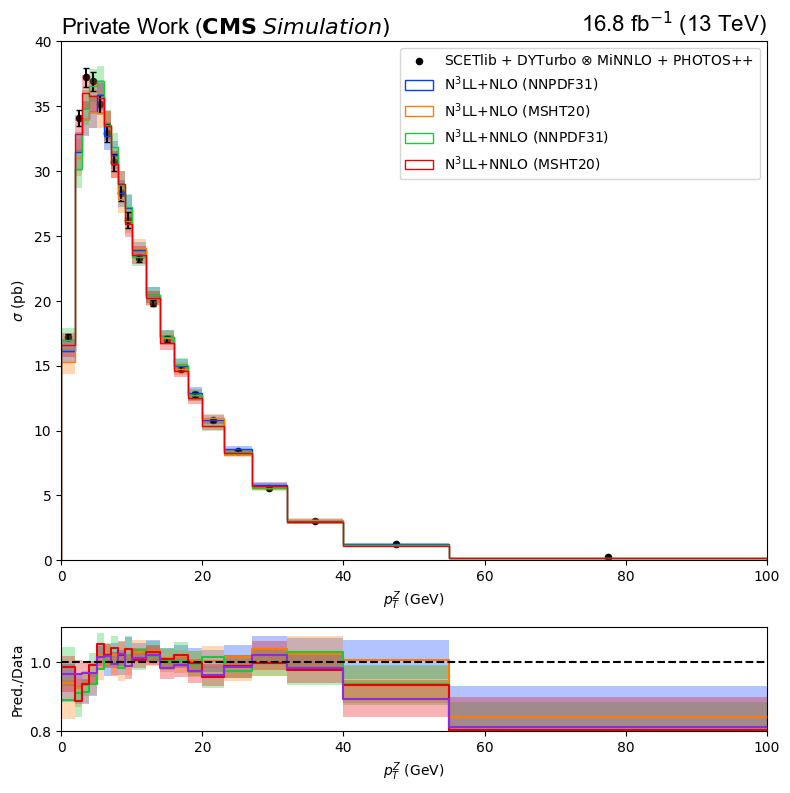

In [10]:
# Compare transverse momentum plots
def compare_pT(parts_cp, pT_low):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={"height_ratios": [5, 1]})
    values_pT, values_eta, errors_pT, errors_eta = extract(prefitfile)
    edges_pT = bins_pT
    edges_pT_centres = (edges_pT[:-1] + edges_pT[1:]) / 2
    label = r"SCETlib + DYTurbo $\otimes$ MiNNLO + PHOTOS++"
    ax1.scatter(edges_pT_centres, values_pT, label=label, s=20, color="black")
    ax1.errorbar(edges_pT_centres, values_pT, yerr=errors_pT, fmt="none", ecolor="black", capsize=2)
    files_cp_pT = check_pgoal(sel_files(parts_cp)[0])
    for i, file in enumerate(files_cp_pT):
        lhapdf = file.split("_")[2]
        part = file.split("_")[4]
        name = file[len(f"Result MCFM Real Data/Z_data_{lhapdf}_"):-len(".txt")]
        label = part_dict[part] + f" ({lhapdf})"
        edges, values, errors = extract(file)
        edges_centres = (edges[:-1] + edges[1:]) / 2
        yerr = errors
        ax1.hist(edges[:-1], bins=edges, weights=values, histtype="step", label=label, color=colors[i])
        ax1.fill_between(edges, np.append(values-errors, values[-1]-errors[-1]), np.append(values+errors, values[-1]+errors[-1]), alpha=0.3, step="post", linewidth=0, color=colors[i])
        ratios = np.append(values/values_pT, values[-1]/values_pT[-1])
        ratios_errors = np.append(yerr/values_pT, yerr[-1]/values_pT[-1])
        ax2.step(edges, ratios, where="post", linestyle="-", label=label, color=colors[i+1])
        ax2.fill_between(edges, ratios - ratios_errors, ratios + ratios_errors, alpha=0.3, step="post", linewidth=0, color=colors[i])
    ax1.set_xlabel(r"$p_T^Z$ (GeV)")
    ax1.set_ylabel(r"$\sigma$ (pb)")
    ax1.legend(loc="upper right")
    add_plot_text(ax1)
    ax1.set_xlim(edges_pT[0], edges_pT[-1] if pT_low is None else pT_low)
    ax2.axhline(1.0, linestyle="--", color="black")
    ax2.set_xlabel(r"$p_T^Z$ (GeV)")
    ax2.set_ylabel("Pred./Data")
    ax2.set_xlim(edges_pT[0], edges_pT[-1] if pT_low is None else pT_low)
    ax2.set_ylim(0.8, 1.1)
    plt.tight_layout()
    plt.savefig(f"Figure MCFM Real Data/sigma vs pT{'' if pT_low is None else pT_low} for real data {len(parts_cp)} sets Z.png")

compare_pT(parts_cp, None)

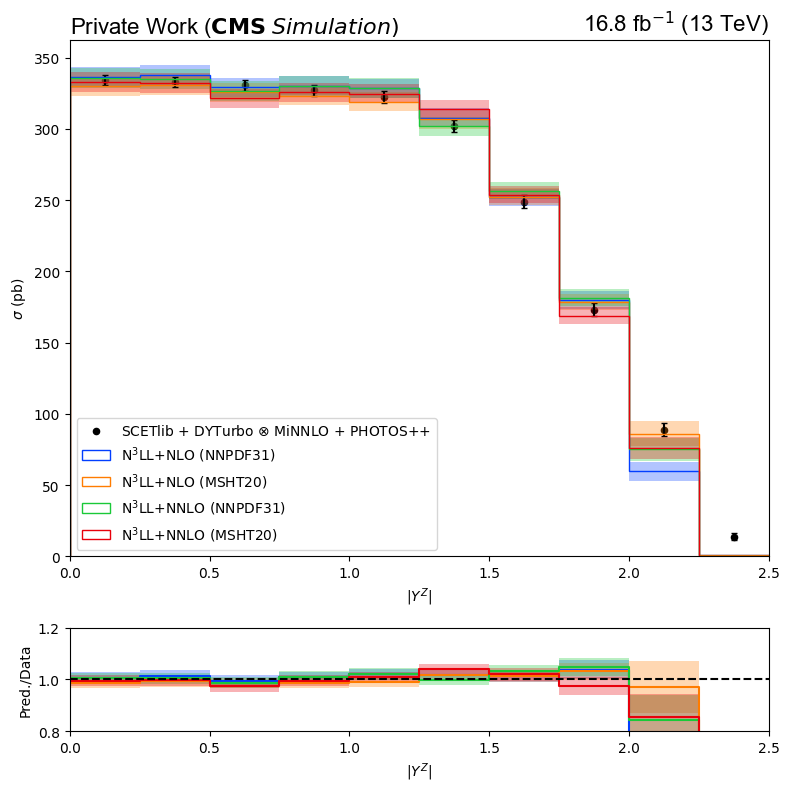

In [11]:
# Compare rapidity plots
def compare_eta(parts_cp):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={"height_ratios": [5, 1]})
    values_pT, values_eta, errors_pT, errors_eta = extract(prefitfile)
    edges_eta = bins_eta
    edges_eta_centres = (edges_eta[:-1] + edges_eta[1:]) / 2
    label = r"SCETlib + DYTurbo $\otimes$ MiNNLO + PHOTOS++"
    ax1.scatter(edges_eta_centres, values_eta, label=label, s=20, color="black")
    ax1.errorbar(edges_eta_centres, values_eta, yerr=errors_eta, fmt="none", ecolor="black", capsize=2)
    files_cp_eta = check_pgoal(sel_files(parts_cp)[1])
    for i, file in enumerate(files_cp_eta):
        lhapdf = file.split("_")[2]
        part = file.split("_")[4]
        name = file[len(f"Result MCFM Inclusive/Z_data_{lhapdf}_"):-len(".txt")]
        label = part_dict[part] + f" ({lhapdf})"
        edges, values, errors = extract(file)
        edges_centres = (edges[:-1] + edges[1:]) / 2
        yerr = errors
        ax1.hist(edges[:-1], bins=edges, weights=values, histtype="step", label=label, color=colors[i])
        ax1.fill_between(edges, np.append(values-errors, values[-1]-errors[-1]), np.append(values+errors, values[-1]+errors[-1]), alpha=0.3, step="post", linewidth=0, color=colors[i])
        ratios = np.append(values/values_eta, values[-1]/values_eta[-1])
        ratios_errors = np.append(yerr/values_eta, yerr[-1]/values_eta[-1])
        ax2.step(edges, ratios, where="post", linestyle="-", label=label, color=colors[i])
        ax2.fill_between(edges, ratios - ratios_errors, ratios + ratios_errors, alpha=0.3, step="post", linewidth=0, color=colors[i])
    ax1.set_xlabel(r"$|Y^Z|$")
    ax1.set_ylabel(r"$\sigma$ (pb)")
    ax1.legend(loc="lower left")
    add_plot_text(ax1)
    ax1.set_xlim(0, 2.5)
    ax2.axhline(1.0, linestyle="--", color="black")
    ax2.set_xlabel(r"$|Y^Z|$")
    ax2.set_ylabel("Pred./Data")
    ax2.set_xlim(0, 2.5)
    ax2.set_ylim(0.8, 1.2)
    plt.tight_layout()
    plt.savefig(f"Figure MCFM Real Data/sigma vs abs(Y) for real data {len(parts_cp)} sets Z.png")
    plt.show()

compare_eta(parts_cp)

In [12]:
# Extract data from text file
def extract_bin(file):
    # Open the text file
    if file.endswith(".hdf5"):
        file = h5py.File(file, "r")
        values, errors = zip(*file["data_ZptVGen_absYVGen"])
        values, errors = np.array(values), np.sqrt(np.array(errors))
        return values, errors
    else:
        with open(file, "r") as f:
            if any(file.endswith(f"pT_{i}.txt") for i in range(3, 12+1)):
                # Skip the first 5 rows
                for i in range(5):
                    f.readline()
                # Extract the data
                data = [line.split() for line in f.readlines()]
                edges = np.append(np.array([float(row[0]) for row in data]), 100.0)
                values = np.array([float(row[2])/1000 for row in data])
                errors = np.array([float(row[3])/1000 for row in data])
                return edges, values, errors

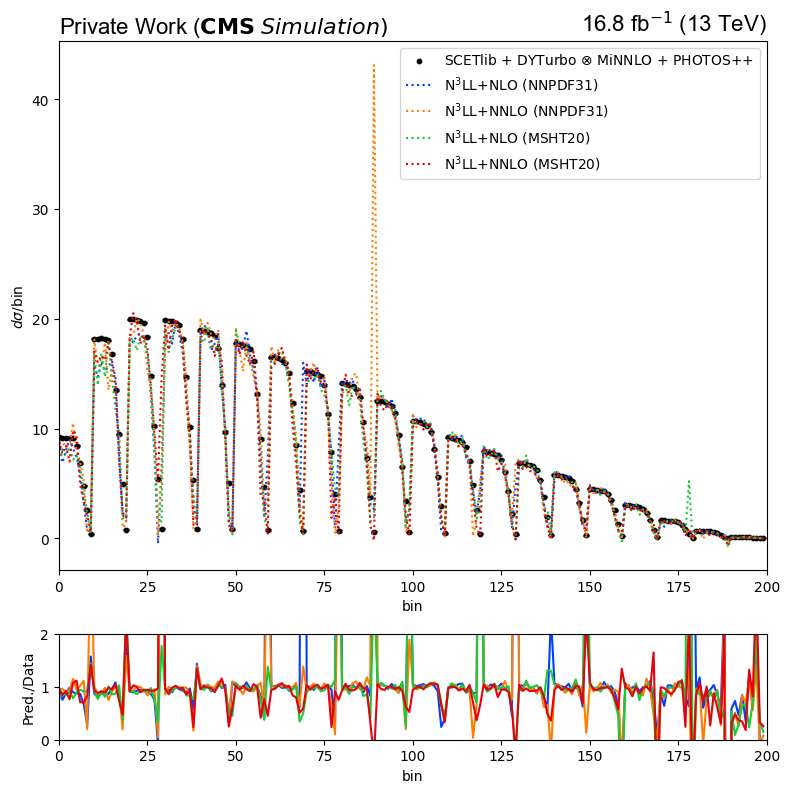

In [13]:
# Plot variable vs real data
def plot_vs_data(parts_cp):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={"height_ratios": [5, 1]})
    values_Zmumu, errors_Zmumu = extract_bin(prefitfile)
    label = r"SCETlib + DYTurbo $\otimes$ MiNNLO + PHOTOS++"
    ax1.scatter(np.arange(len(values_Zmumu)), values_Zmumu/bin_widths, label=label, s=10, color="black")
    ax1.errorbar(np.arange(len(values_Zmumu)), values_Zmumu/bin_widths, yerr=errors_Zmumu, fmt="none", ecolor="black", capsize=2)
    label = r"SCETlib + DYTurbo $\otimes$ MiNNLO + PHOTOS++"
    for lhapdf in lhapdfs:
        for part in parts_cp:
            nproc, ewcorr, pgoal = "31", "none", "0.001"
            label = part_dict[part] + f" ({lhapdf})"
            name = "_".join([nproc, part, ewcorr, pgoal])
            files = []
            values_array = []
            errors_array = []
            for i in range(3, 12+1):
                files.append(f"Z_data_{lhapdf}_{name}_pT_{i}.txt")
            files = check_pgoal(files)
            for file in files:
                if not file.startswith("Result MCFM Real Data/"):
                    file = "Result MCFM Real Data/" + file
                edges, values, errors = extract_bin(file)
                values_array.append(values)
                errors_array.append(errors)
            values = np.array(values_array).T.flatten() # Transpose the 2D array and flatten it into a 1D array
            errors = np.array(errors_array).T.flatten() # Transpose the 2D array and flatten it into a 1D array
            ax1.plot(np.arange(len(values)), values/bin_widths, linestyle=":", label=f"{label}")
            ratios = values/values_Zmumu
            ax2.plot(np.arange(len(values)), ratios, "-", label=f"{label}")
    ax1.set_xlabel("bin")
    ax1.set_ylabel(r"$d\sigma$/bin")
    ax1.set_xlim(0, len(values_Zmumu))
    ax1.legend()
    add_plot_text(ax1)
    ax2.set_xlim(0, len(values_Zmumu))
    ax2.set_ylim(0, 2)
    ax2.set_xlabel("bin")
    ax2.set_ylabel("Pred./Data")
    plt.tight_layout()
    plt.savefig(f"Figure MCFM Real Data/sigma vs bin for real data {len(parts_cp)} sets Z.png")
    plt.show()

plot_vs_data(parts_cp)

n_error_train = 49
n_error_test = 81 for NNPDF31 (N3LL+NLO)


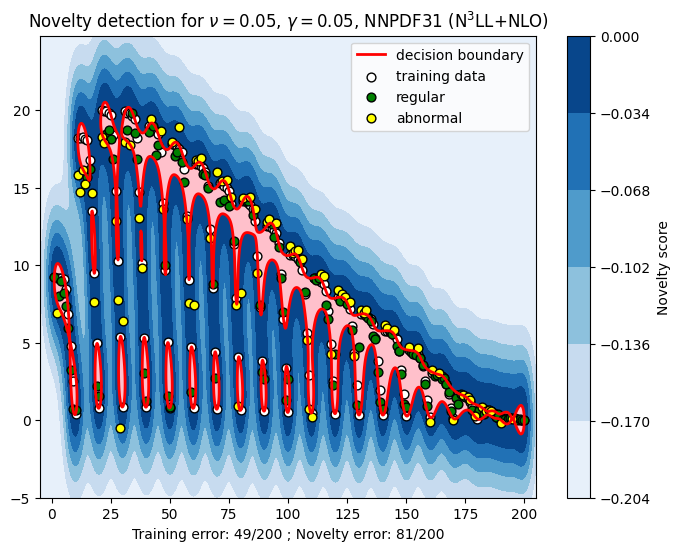

n_error_test = 75 for NNPDF31 (N3LL+NNLO)


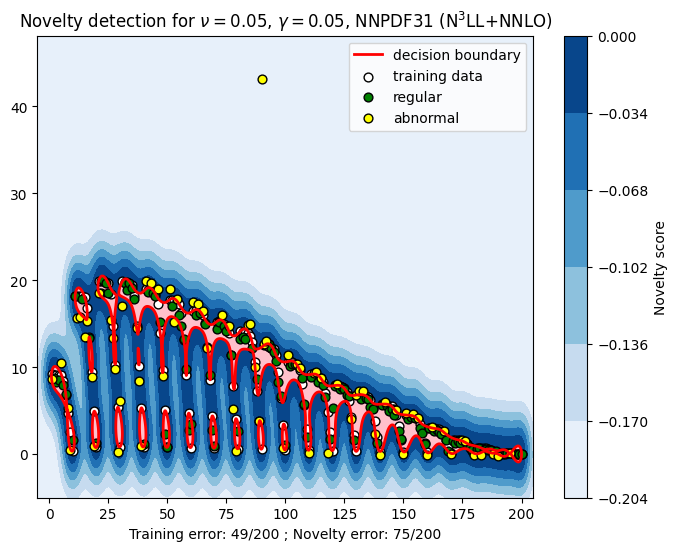

n_error_test = 64 for MSHT20 (N3LL+NLO)


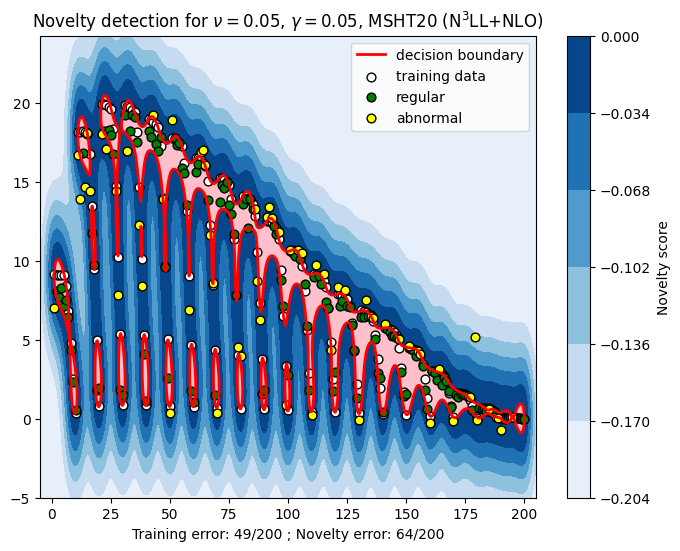

n_error_test = 66 for MSHT20 (N3LL+NNLO)


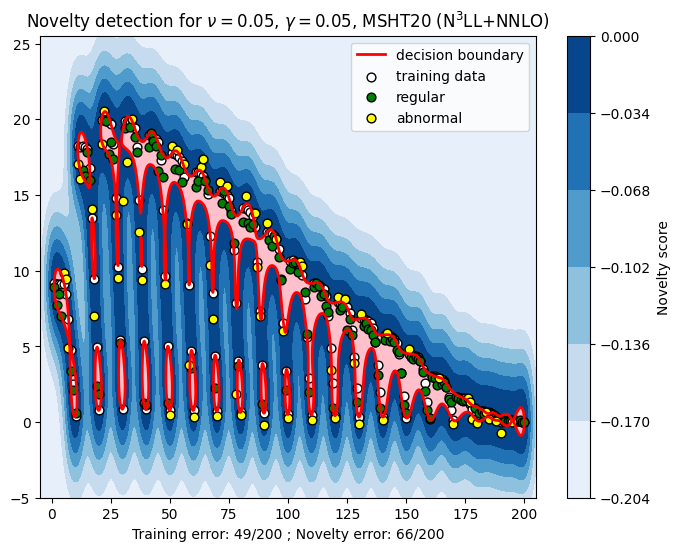

n_error_train = 26
n_error_test = 52 for NNPDF31 (N3LL+NLO)


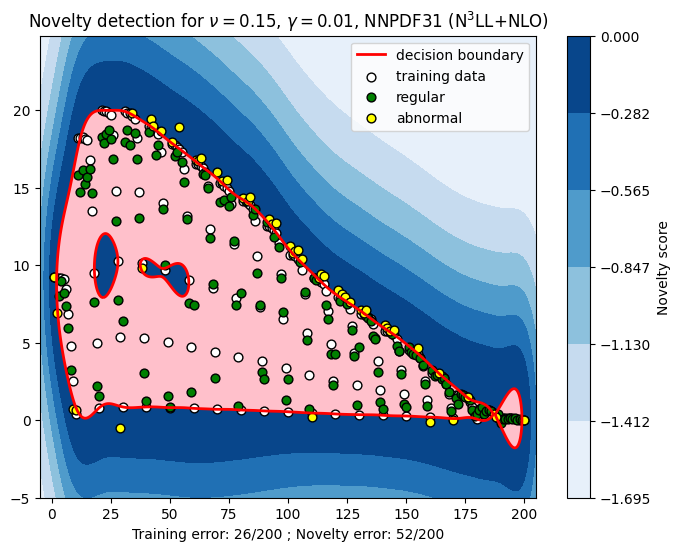

n_error_test = 47 for NNPDF31 (N3LL+NNLO)


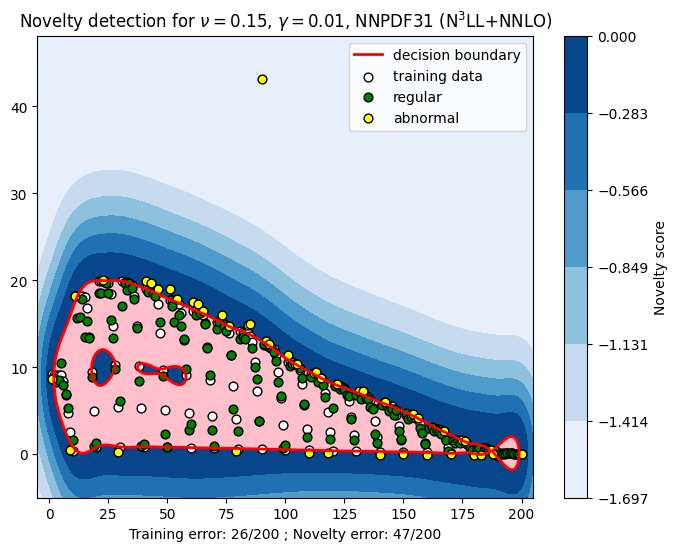

n_error_test = 37 for MSHT20 (N3LL+NLO)


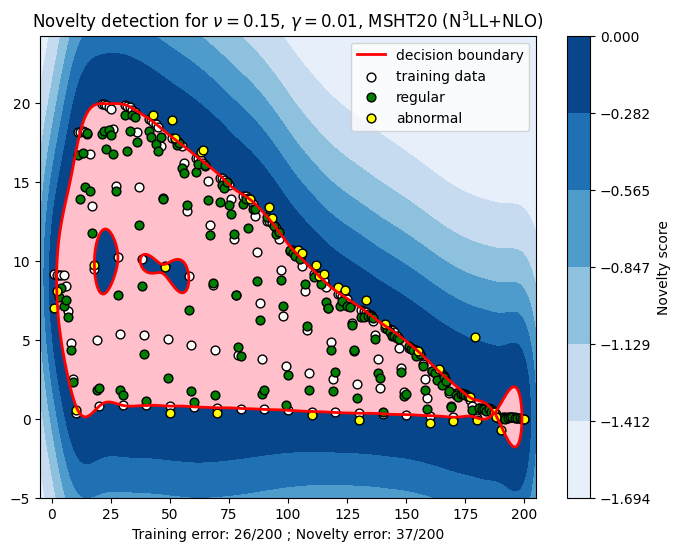

n_error_test = 44 for MSHT20 (N3LL+NNLO)


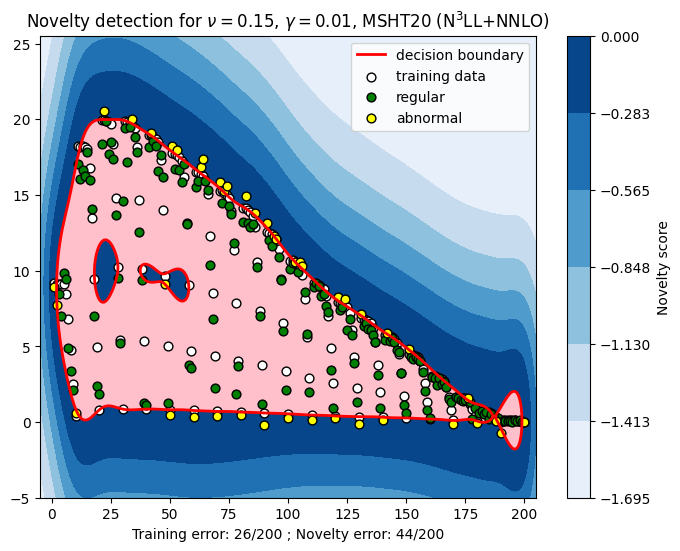

n_error_train = 75
n_error_test = 108 for NNPDF31 (N3LL+NLO)


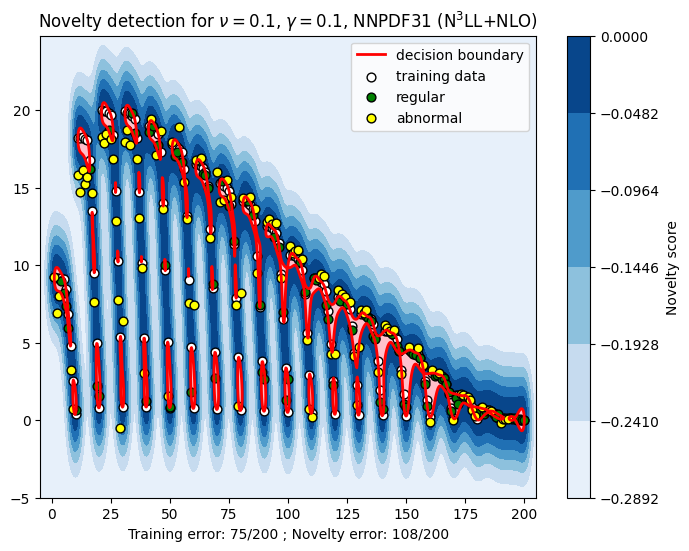

n_error_test = 95 for NNPDF31 (N3LL+NNLO)


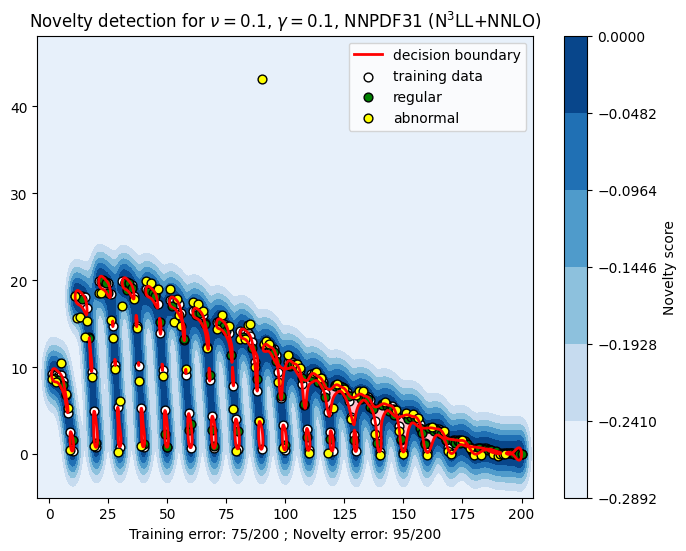

n_error_test = 98 for MSHT20 (N3LL+NLO)


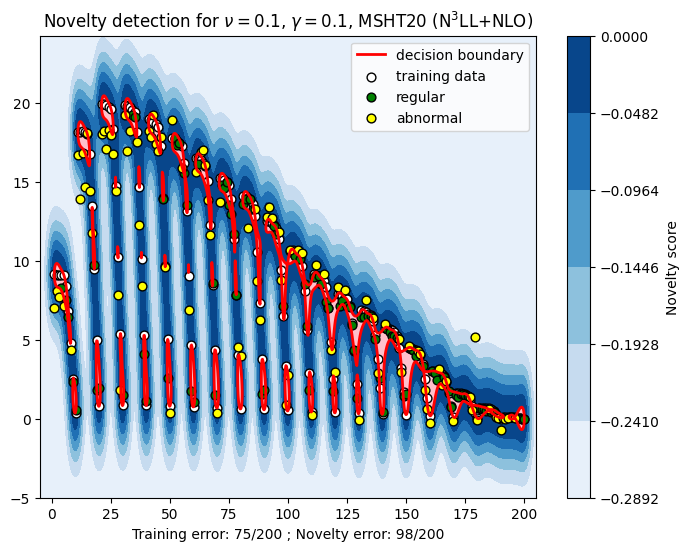

n_error_test = 108 for MSHT20 (N3LL+NNLO)


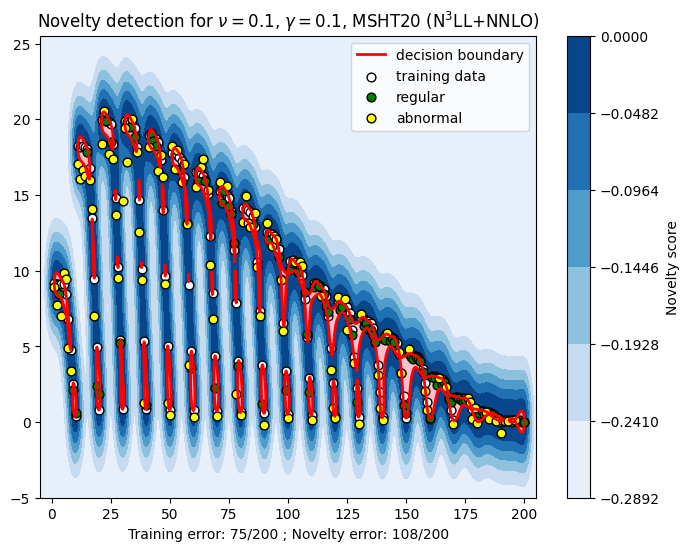

In [14]:
# Extract values and errors from prefitfile
values_Zmumu, errors_Zmumu = extract_bin(prefitfile)
bins = np.arange(1, len(values_Zmumu) + 1)

# Fit the model
def anomaly(nu, gamma):
    clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma)
    X_train = np.column_stack((bins, values_Zmumu / bin_widths))
    clf.fit(X_train)
    y_pred_train = clf.predict(X_train)
    n_error_train = y_pred_train[y_pred_train == -1].size
    print("n_error_train =", n_error_train)

    # Detect anomaly in MCFM results
    for lhapdf in lhapdfs:
        for part in parts_cp:
            nproc, ewcorr, pgoal = "31", "none", "0.001"
            label = part_dict[part] + f" ({lhapdf})"
            name = "_".join([nproc, part, ewcorr, pgoal])
            files = []
            values_array = []
            errors_array = []
            for i in range(3, 12 + 1):
                files.append(f"Z_data_{lhapdf}_{name}_pT_{i}.txt")
            files = check_pgoal(files)
            for file in files:
                if not file.startswith("Result MCFM Real Data/"):
                    file = "Result MCFM Real Data/" + file
                edges, values, errors = extract_bin(file)
                values_array.append(values)
                errors_array.append(errors)
            values = np.array(values_array).T.flatten()  # Transpose the 2D array and flatten it into a 1D array
            errors = np.array(errors_array).T.flatten()  # Transpose the 2D array and flatten it into a 1D array

            # Prepare test data
            X_test = np.column_stack((bins, values / bin_widths))
            y_pred_test = clf.predict(X_test)
            n_error_test = y_pred_test[y_pred_test == -1].size
            label = part_dict[part].replace("$\mathrm{N}^3$", "N3")
            print(f"n_error_test = {n_error_test} for {lhapdf} ({label})")

            # Visualization of the result
            xx, yy = np.meshgrid(np.linspace(-5, 205, 1000), np.linspace(-5, np.max(X_test[:, 1]) + 5, 1000))
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

            # Plot the result
            plt.figure(figsize=(8, 6))
            plt.title(fr"Novelty detection for $\nu={nu}$, $\gamma={gamma}$, {lhapdf} ({part_dict[part]})")
            plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap="Blues")
            plt.colorbar().set_label("Novelty score")
            contour = plt.Line2D([0], [0], color="red", linewidth=2) # create a Line2D object for the legend
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="red")
            plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="pink")
            train = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=40, edgecolors="black")
            regular = plt.scatter(X_test[y_pred_test == 1, 0], X_test[y_pred_test == 1, 1], c="green", s=40, edgecolors="black")
            abnormal = plt.scatter(X_test[y_pred_test == -1, 0], X_test[y_pred_test == -1, 1], c="yellow", s=40, edgecolors="black")
            plt.axis("tight")
            plt.xlim(xx.min(), xx.max())
            plt.ylim(yy.min(), yy.max())
            plt.legend([contour, train, regular, abnormal], ["decision boundary", "training data", "regular", "abnormal"], loc="best")
            plt.xlabel(f"Training error: {n_error_train}/200 ; Novelty error: {n_error_test}/200")
            plt.savefig(f"Figure MCFM Real Data/Novelty detection MCFM {nu}_{gamma}_{lhapdf}_{part}.png")
            plt.show()

anomaly(0.05, 0.05)
anomaly(0.15, 0.01)
anomaly(0.1, 0.1)

In [21]:
# Find the optimal parameters to minimize n_error_train

# Initialize variables
min_n_error_train = float("inf")
opt_nu = None
opt_gamma = None

# Iterate over combinations of nu and gamma values
for nu, gamma in tqdm(itertools.product(np.arange(0.01, 1.01, 0.01), np.arange(0.01, 1.01, 0.01))):
    try:
        # Fit the model
        clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma)
        X_train = np.column_stack((bins, values_Zmumu / bin_widths))
        clf.fit(X_train)
        y_pred_train = clf.predict(X_train)
        n_error_train = y_pred_train[y_pred_train == -1].size
        
        # Update the minimum error count and optimal parameters if necessary
        if n_error_train < min_n_error_train:
            min_n_error_train = n_error_train
            opt_nu = nu
            opt_gamma = gamma
    except Exception:
        pass

# Print the result
print(f"optimal nu = {opt_nu}")
print(f"optimal gamma = {opt_gamma}")
print(f"minimum n_error_train = {min_n_error_train}")

10000it [00:35, 282.62it/s]

optimal nu = 0.15000000000000002
optimal gamma = 0.01
minimum n_error_train = 26
